In [1]:
import logging

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from neural_bandits.bandits.neural_ucb_bandit import NeuralUCBBandit
from neural_bandits.benchmark.datasets.mnist import MNISTDataset
from neural_bandits.utils.data_sampler import SortedDataSampler

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
dataset = MNISTDataset()
print(dataset.context_size)
print(len(dataset))

network = Network(dataset.context_size * dataset.num_actions, hidden_size=100)

sorted_sampler = SortedDataSampler(
    data_source=Subset(dataset, range(10000)),
    key_fn=lambda idx: int(dataset.y[idx]),
)

784
70000


In [4]:
accelerator = "mps"

train_loader = DataLoader(
    Subset(dataset, range(10000)), 
    sampler=sorted_sampler,
    batch_size=32
)
env = BanditBenchmarkEnvironment(train_loader, device=accelerator)
bandit_module = NeuralUCBBandit(
    n_features = dataset.context_size * dataset.num_actions,
    network=network,
    early_stop_threshold=1e-2,
    num_grad_steps=100,
    lambda_=0.00001,
    nu=0.00001,
    learning_rate=1e-2,
    train_freq=2,
    initial_train_steps=150,
    max_grad_norm=50.0,
).to(accelerator)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(CSVLogger("logs", name="neural_ucb_bandit", flush_logs_every_n_steps=100))

In [5]:
for contextualized_actions in env:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
    feedback = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)
    logger.pre_training_log({"regret": batch_regret.sum().item()})

    batch_dataloader = DataLoader(feedback, batch_size=32)
    trainer.fit(bandit_module, batch_dataloader)
    bandit_module = bandit_module.to(accelerator)

/Users/robert/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Step: 0 {'training_run': 312, 'loss': 0.0006064358749426901, 'reward': 12.0, 'epoch': 0, 'regret': 4.0}}}

In [11]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:10000])
cumulative_regret = np.cumsum(metrics["regret"][:10000].dropna())

logs/neural_ucb_bandit/version_35/metrics.csv


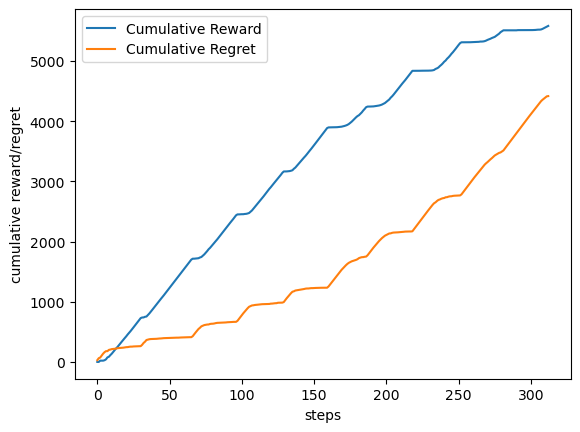

In [12]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward, label='Cumulative Reward')
plt.plot(cumulative_regret, label='Cumulative Regret')
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [13]:
metrics

,epoch,loss,regret,reward,step,training_run
0,0,0.002489,31.0,1.0,0,0
1,0,0.000772,32.0,0.0,0,1
2,0,0.006597,11.0,21.0,0,2
3,0,0.009723,32.0,0.0,0,3
4,0,0.004533,32.0,0.0,0,4
...,...,...,...,...,...,...
308,0,0.000483,23.0,9.0,0,308
309,0,0.000661,19.0,13.0,0,309
310,0,0.000541,18.0,14.0,0,310
311,0,0.000693,21.0,11.0,0,311


In [9]:
# average reward
print(sum(metrics["reward"][:10]) / 10)
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:10].dropna()) / 10)
print(sum(metrics["regret"][:100].dropna()) / 100)
print(sum(metrics["regret"][:10000].dropna()) / 10000)

11.4
24.54
0.5583
20.6
7.46
0.4417


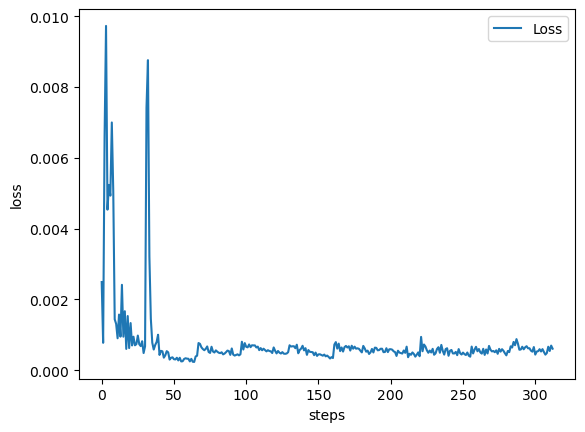

In [14]:
plt.plot(metrics["loss"][:1000], label='Loss')
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()